In [69]:
import sys
sys.path.append('/Users/aleix11alcacer/Projects/archetypes')

import numpy as np
import torch
from models import BiAA, SBM, DBiAA, DSBM
from archetypes.datasets import sort_by_archetype_similarity, make_archetypal_dataset, shuffle_dataset
from archetypes.visualization import heatmap
from itertools import product
from sklearn.metrics import normalized_mutual_info_score
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from tqdm.auto import tqdm
from sklearn.metrics import average_precision_score, roc_auc_score

In [70]:
n_archetypes = (3, 3)

archetypes = np.array(
    [
        [0.3, 0.6, 0.7],
        [0.5, 0.5, 0.3],
        [0.3, 0.5, 0.7],
    ]
)

shape = (200, 200)

alphas = [0, 0.25, 0.5, 1]
models = [BiAA, SBM]
assignments = ["soft"]

results = None
results_loss = None

dict_archetypes = {}
dict_nmi = {}

for alpha in tqdm(alphas, leave=False):

    generator = np.random.default_rng(0)
    data, labels = make_archetypal_dataset(
        archetypes,
        shape,
        alpha=alpha,
        generator=generator,
        noise=0.1
    )

    data = np.clip(data, 0, 1)

    data = generator.binomial(1, data)  # binarize the data

    data_shuffle, info_shuffle = shuffle_dataset(data, generator=generator)
    a = torch.tensor(data_shuffle, dtype=torch.float32)
        
    biaa_model = None
    for assignment, model in tqdm(list(product(assignments, models)), leave=False):
        auc_j = -np.inf
        prauc_j = -np.inf
        best_model = None
        for _ in tqdm(range(5), leave=False):
            if model in [BiAA, DBiAA]:
                model_i = model(n_archetypes, a, likelihood="bernoulli", assignment=assignment,
                                device="cpu")
            else:
                model_i = model(n_archetypes, a, likelihood="bernoulli", assignment=assignment,
                                device="cpu", biaa_model=biaa_model)

            model_i.fit(2_000, learning_rate=0.05, threshold=0)

            if not best_model or best_model.losses[-1] < model_i.losses[-1]:
                best_model = model_i

        if model in [BiAA, DBiAA]:
            biaa_model = best_model
            
        
        # compute the similarity between the archetypes and the true archetypes
        from models.metrics import normalized_mutual_info_score
        
        nmi = normalized_mutual_info_score(torch.tensor(archetypes).float(), best_model.Z)
        dict_archetypes[(assignment, model.__name__, alpha)] = best_model.Z.detach().numpy()
        dict_nmi[(assignment, model.__name__, alpha)] = nmi

        # print(f"{assignment} {model.__name__} NMI: {nmi}")
        

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

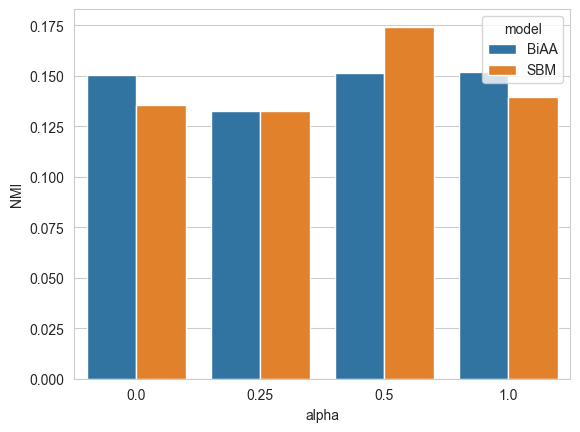

In [71]:
import seaborn as sns

df = pd.DataFrame.from_dict(dict_nmi, orient="index").reset_index()

# extract tuple values from first column
df[["assignment", "model", "alpha"]] = pd.DataFrame(df["index"].tolist(), index=df.index)

# remove index column
df = df.drop(columns=["index"])

# rename columns
df = df.rename(columns={0: "NMI"})


sns.barplot(data=df, x="alpha", y="NMI", hue="model")

plt.show()

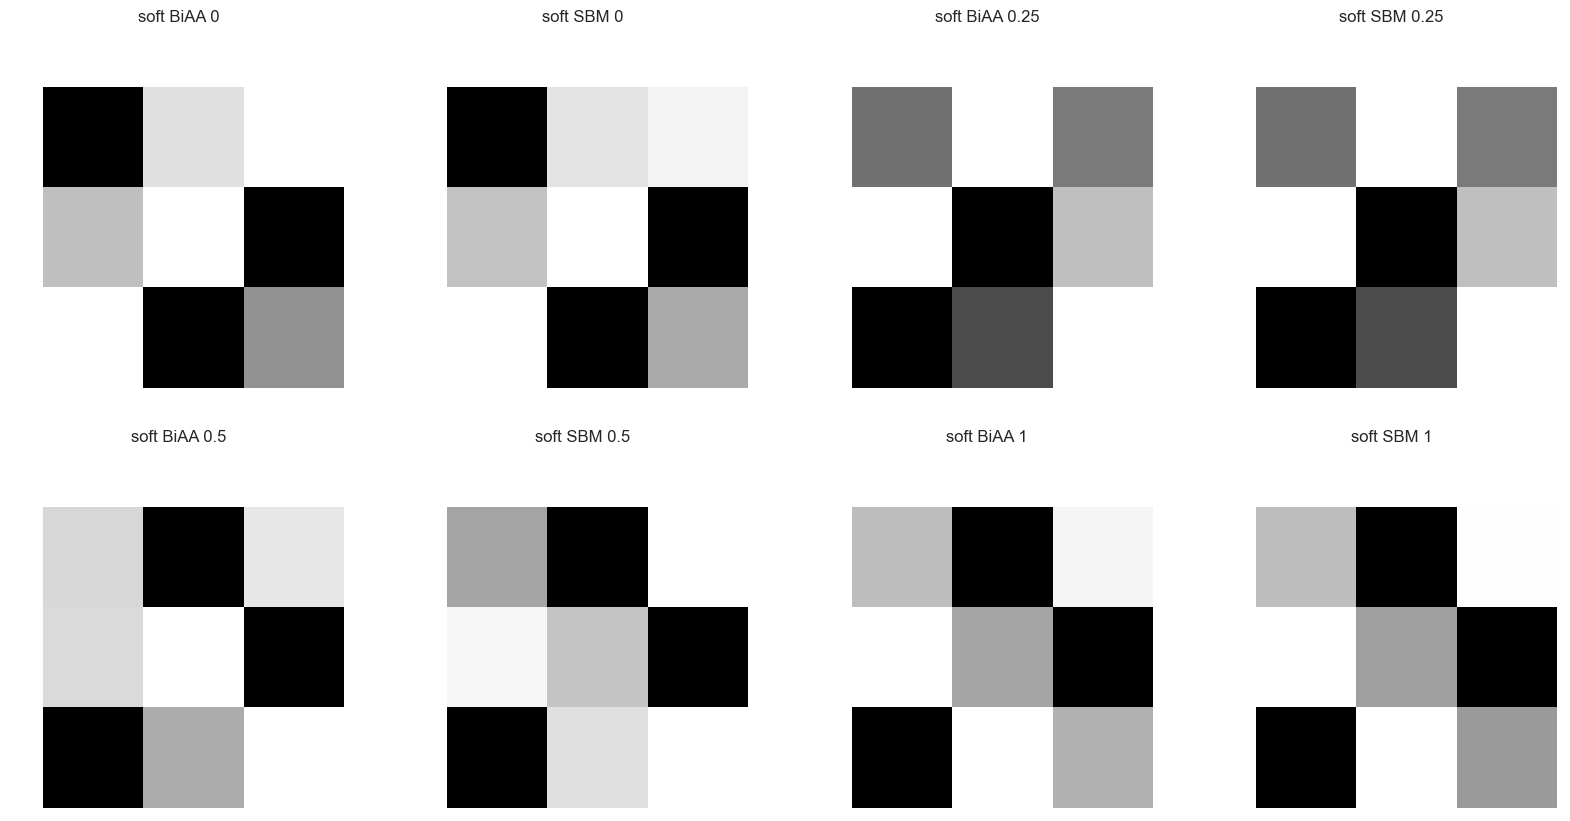

In [72]:
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.flatten()
for i, ((assignment, model, alpha), arch) in enumerate(dict_archetypes.items()):
    heatmap(arch, vmin=0, vmax=1, ax=axes[i])
    axes[i].set_title(f"{assignment} {model} {alpha}")

<Axes: >

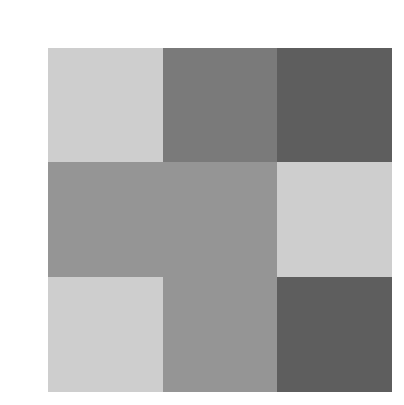

In [73]:
heatmap(archetypes, vmin=0, vmax=1)